In [ ]:
# Instalar dependencias
!pip -q install "transformers>=4.45,<5" "datasets>=2.19,<4" jiwer librosa soundfile tqdm --upgrade
print("✅ Dependencias instaladas")

In [ ]:
import torch
import sys

# Configurar device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Usando: {device}")
if device.type == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Agregar directorio actual al path para imports
sys.path.append("/content")

🖥️  Usando: cuda
   GPU: NVIDIA A100-SXM4-40GB
   Memoria disponible: 42.47 GB


In [ ]:
# 🎯 PARÁMETROS CLAVE DEL EXPERIMENTO

# Parámetros de generación para Whisper
gen_kwargs = {
    "return_dict_in_generate": True,
    "output_scores": False,
    "output_hidden_states": True,
    "output_attentions": False
}

embedding_kwargs = {
    "use_decoder": False,
    "use_encoder": True
}

# Hiperparámetros del algoritmo
TOP_K = 1                    # Número de capas top-k por Block Influence
BATCH_HIST_SIZE = 100        # Cada 100 audios genera un histograma
NUM_BINS = 20                # Bins del histograma
N_TEST_SAMPLES = None          # Número de muestras de test para evaluar

print(f"⚙️  Configuración:")
print(f"   • Top-K capas: {TOP_K}")
print(f"   • Batch histograma: {BATCH_HIST_SIZE} audios")
print(f"   • Bins por histograma: {NUM_BINS}")
print(f"   • Muestras de test: {N_TEST_SAMPLES}")


⚙️  Configuración:
   • Top-K capas: 1
   • Batch histograma: 100 audios
   • Bins por histograma: 20
   • Muestras de test: None


In [ ]:
import numpy as np
import torch
from whisper_wrapper import WhisperWrapper
from feature_density_estimator import FeatureDensityEstimator
from dataloader import Dataloader

def run_single_model_experiment(
    model_id: int = 1,
    top_k: int = TOP_K,
    batch_hist_size: int = BATCH_HIST_SIZE,
    num_bins: int = NUM_BINS,
    n_test_samples = None,
    device = device
):
    """
    Ejecuta experimento para un modelo específico.

    Args:
        model_id: ID del modelo (1-10)
        top_k: Número de capas top-k
        batch_hist_size: Audios por batch para histograma
        num_bins: Número de bins del histograma
        n_test_samples: Muestras de test (None = todas)

    Returns:
        tuple: (uq_scores, wers, pearson_corr)
    """
    print(f"\n{'='*60}")
    print(f"🔬 MODELO {model_id:02d}")
    print(f"{'='*60}")

    # 1. Cargar modelo
    model_name = f"danrdz/whisper-finetuned-es-modelo_{model_id:02d}"
    print(f"📥 Cargando {model_name}...")
    model_wrapper = WhisperWrapper(model_name, device=device)
    fde = FeatureDensityEstimator(model_wrapper)

    # 2. Cargar datos
    print(f"📊 Cargando datos (partición {model_id})...")
    _, finetune_audios = Dataloader.load_uq_partitions("fine-tune", model_id, model_id + 1)
    test_ds, test_audios = Dataloader.load_uq_partitions("test", model_id, model_id + 1)

    print(f"   • Fine-tune: {len(finetune_audios[0])} audios")
    print(f"   • Test: {len(test_audios[0])} audios")

    # 3. Funciones de agregación
    aggregation_fn = lambda xs: torch.cat(xs, dim=1).squeeze()
    reduction_fn = lambda x: torch.flatten(x)

    # 4. Generar ENSEMBLE de histogramas
    print(f"\n🎲 Generando ensemble de histogramas...")
    print(f"   • Procesando en lotes de {batch_hist_size} audios")
    print(f"   • Esperados: ~{len(finetune_audios[0]) // batch_hist_size} histogramas")

    # Monkey-patch para control de num_bins
    orig_gen_hist = fde._generate_histogram
    def gen_hist_wrapper(embeddings, reduction_fn):
        return orig_gen_hist(embeddings, reduction_fn, num_bins=num_bins)
    fde._generate_histogram = gen_hist_wrapper

    all_histograms = fde.generate_feature_densities(
        finetune_audios[0],
        top_k,
        aggregation_fn,
        reduction_fn,
        gen_kwargs,
        embedding_kwargs,
        batch_size=batch_hist_size
    )

    print(f"   ✅ Generados {len(all_histograms)} histogramas")

    # 5. Determinar cuántas muestras usar
    if n_test_samples is None:
        # Usar TODAS las muestras
        test_subset_ds = test_ds[0]
        test_subset_audios = test_audios[0]
        n_actual = len(test_audios[0])
        print(f"\n📏 Usando TODAS las muestras de test: {n_actual}")
    else:
        # Usar solo n_test_samples
        test_subset_ds = test_ds[0].select(range(n_test_samples))
        test_subset_audios = test_audios[0][:n_test_samples]
        n_actual = n_test_samples
        print(f"\n📏 Usando subset de {n_actual} muestras")

    # 6. Calcular UQ scores
    print(f"\n📈 Calculando UQ scores para {n_actual} muestras...")
    print(f"   • Evaluando contra {len(all_histograms)} histogramas")
    print(f"   ⏳ Esto puede tomar varios minutos...")

    uq_scores = fde.eval_likelihood(
        test_subset_audios,
        all_histograms,
        gen_kwargs,
        reduction_fn,
        aggregation_fn
    )

    # 7. Calcular WER
    print(f"\n🎤 Transcribiendo y calculando WER para {n_actual} muestras...")
    print(f"   ⏳ Esto puede tomar varios minutos...")
    transcriptions, ground_truths = model_wrapper.transcribe_dataset(test_subset_ds)
    wers = model_wrapper.compute_wers(transcriptions, ground_truths)

    # 8. Calcular correlación
    uq_array = np.array(uq_scores)
    wer_array = np.array(wers)
    pearson_corr = np.corrcoef(uq_array, wer_array)[0, 1]

    print(f"\n📊 RESULTADOS:")
    print(f"   • N muestras evaluadas: {n_actual}")
    print(f"   • Correlación (UQ vs WER): {pearson_corr:.4f}")
    print(f"   • WER promedio: {wer_array.mean():.4f} ± {wer_array.std():.4f}")
    print(f"   • UQ score promedio: {uq_array.mean():.2f} ± {uq_array.std():.2f}")

    return uq_array, wer_array, pearson_corr

# Test con el primer modelo (TODOS los audios)
uq, wer, corr = run_single_model_experiment(model_id=1, n_test_samples=None)

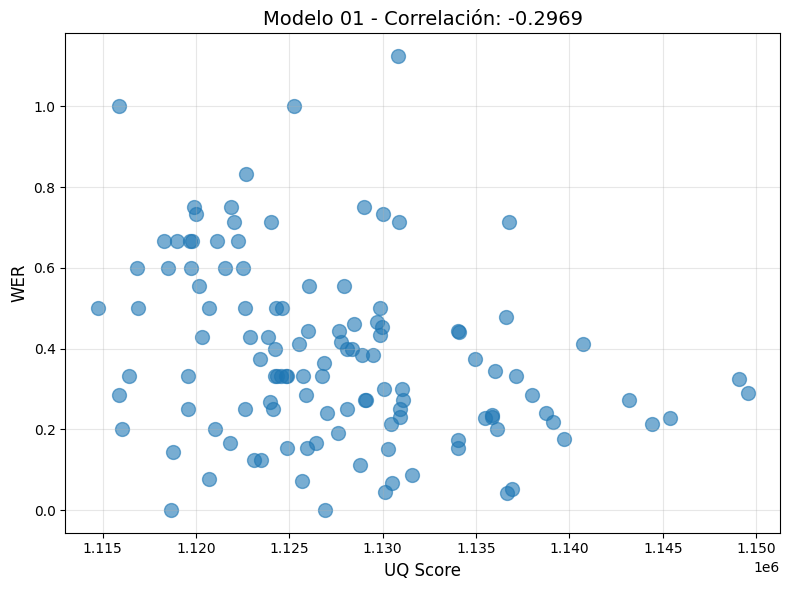

In [ ]:
import matplotlib.pyplot as plt

def plot_uq_vs_wer(uq_scores, wers, model_id, corr):
    """Visualiza la relación entre UQ scores y WER"""
    plt.figure(figsize=(8, 6))
    plt.scatter(uq_scores, wers, alpha=0.6, s=100)
    plt.xlabel("UQ Score", fontsize=12)
    plt.ylabel("WER", fontsize=12)
    plt.title(f"Modelo {model_id:02d} - Correlación: {corr:.4f}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualizar
plot_uq_vs_wer(uq, wer, model_id=1, corr=corr)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def run_all_models_experiment(model_ids=range(1, 11)):
    """Ejecuta experimento para múltiples modelos"""
    results = []

    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    axes = axes.flatten()

    for idx, model_id in enumerate(model_ids):
        try:
            uq, wer, corr = run_single_model_experiment(model_id)

            # Guardar resultados
            results.append({
                "Model ID": model_id,
                "Pearson R": corr,
                "Mean WER": wer.mean(),
                "Std WER": wer.std(),
                "Mean UQ": uq.mean(),
                "Std UQ": uq.std()
            })

            # Plot
            axes[idx].scatter(uq, wer, alpha=0.6)
            axes[idx].set_xlabel("UQ Score")
            axes[idx].set_ylabel("WER")
            axes[idx].set_title(f"Modelo {model_id:02d}\nR={corr:.3f}")
            axes[idx].grid(True, alpha=0.3)

        except Exception as e:
            print(f"❌ Error en modelo {model_id}: {e}")
            continue

    plt.tight_layout()
    plt.show()

    # Crear DataFrame con resultados
    df_results = pd.DataFrame(results)

    print("\n" + "="*80)
    print("📊 RESUMEN GENERAL")
    print("="*80)
    print(df_results.to_string(index=False))
    print("\n" + "="*80)
    print(f"🎯 Correlación promedio: {df_results['Pearson R'].mean():.4f} ± {df_results['Pearson R'].std():.4f}")
    print(f"📉 WER promedio: {df_results['Mean WER'].mean():.4f}")
    print("="*80)

    return df_results

# ADVERTENCIA: Esto puede tomar MUCHO tiempo (varios minutos por modelo)
# Descomenta la siguiente línea para ejecutar:
# df_results = run_all_models_experiment()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def run_all_models_with_formatting(
    model_ids=range(1, 11),
    top_k=TOP_K,
    batch_hist_size=BATCH_HIST_SIZE,
    num_bins=NUM_BINS,
    n_test_samples=None
):
    """
    Ejecuta experimento para todos los modelos y genera:
    1. Tabla de resultados
    2. Grid de gráficos de dispersión
    """

    results_list = []
    all_uq_scores = []
    all_wer_scores = []
    all_correlations = []

    # Crear figura para grid de gráficos
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    print("\n" + "="*80)
    print("🚀 INICIANDO EXPERIMENTO PARA TODOS LOS MODELOS")
    print("="*80 + "\n")

    for idx, model_id in enumerate(model_ids):
        try:
            print(f"\n{'─'*80}")
            print(f"Procesando Modelo {model_id}/10...")
            print(f"{'─'*80}")

            # Ejecutar experimento para este modelo
            uq, wer, corr = run_single_model_experiment(
                model_id=model_id,
                top_k=top_k,
                batch_hist_size=batch_hist_size,
                num_bins=num_bins,
                n_test_samples=n_test_samples,
                device=device
            )

            # Guardar resultados
            results_list.append({
                "Model ID": model_id,
                "R": corr,
                "Mean WER": wer.mean(),
                "Std WER": wer.std()
            })

            all_uq_scores.append(uq)
            all_wer_scores.append(wer)
            all_correlations.append(corr)

            # Graficar en el grid
            ax = axes[idx]
            ax.scatter(uq, wer, alpha=0.6, s=50, color='steelblue')
            ax.set_xlabel("UQ Score", fontsize=10)
            ax.set_ylabel("WER", fontsize=10)
            ax.set_title(f"Model {model_id:02d}", fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3, linestyle='--')

            # Añadir texto con correlación
            ax.text(0.05, 0.95, f"R = {corr:.4f}",
                   transform=ax.transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=9)

            print(f"✅ Modelo {model_id} completado")

        except Exception as e:
            print(f"❌ Error en modelo {model_id}: {str(e)}")
            # Dejar subplot vacío con mensaje de error
            ax = axes[idx]
            ax.text(0.5, 0.5, f"Error\nModelo {model_id}",
                   ha='center', va='center',
                   transform=ax.transAxes, fontsize=12, color='red')
            ax.set_xticks([])
            ax.set_yticks([])
            continue

    # Ajustar layout del grid
    plt.tight_layout()
    plt.suptitle("Dispersión por modelo utilizando cuantización dinámica",
                 fontsize=14, fontweight='bold', y=1.02)
    plt.savefig("dispersion_grid.png", dpi=150, bbox_inches='tight')
    plt.show()

    # Crear DataFrame con resultados
    df_results = pd.DataFrame(results_list)

    # Calcular estadísticas globales
    mean_r = df_results["R"].mean()
    mean_wer = df_results["Mean WER"].mean()
    mean_std_wer = df_results["Std WER"].mean()

    # Imprimir resultados en formato tabla
    print("\n" + "="*80)
    print(f"Mean R: {mean_r:.4f}, Mean WER: {mean_wer:.4f}, Mean STD WER: {mean_std_wer:.4f}")
    print("="*80 + " Results " + "="*80)

    # Formatear la tabla con índices comenzando en 0
    df_display = df_results.copy()
    df_display.index = range(len(df_display))

    # Imprimir con formato bonito
    print(df_display.to_string(index=True,
                                float_format=lambda x: f"{x:.6f}",
                                col_space=12))
    print("="*180 + "\n")

    # Guardar CSV
    df_results.to_csv("resultados_cuantizacion_dinamica.csv", index=False)
    print("💾 Resultados guardados en: resultados_cuantizacion_dinamica.csv")

    return df_results, all_uq_scores, all_wer_scores, all_correlations


# EJECUTAR PARA TODOS LOS MODELOS
# ⚠️ ADVERTENCIA: Esto puede tomar 1-3 HORAS dependiendo del tamaño de las particiones
df_results, uq_list, wer_list, corr_list = run_all_models_with_formatting(
    model_ids=range(1, 11),
    n_test_samples=None  # None = todas las muestras
)

💾 Gráfico guardado en: modelo_01_detallado.png


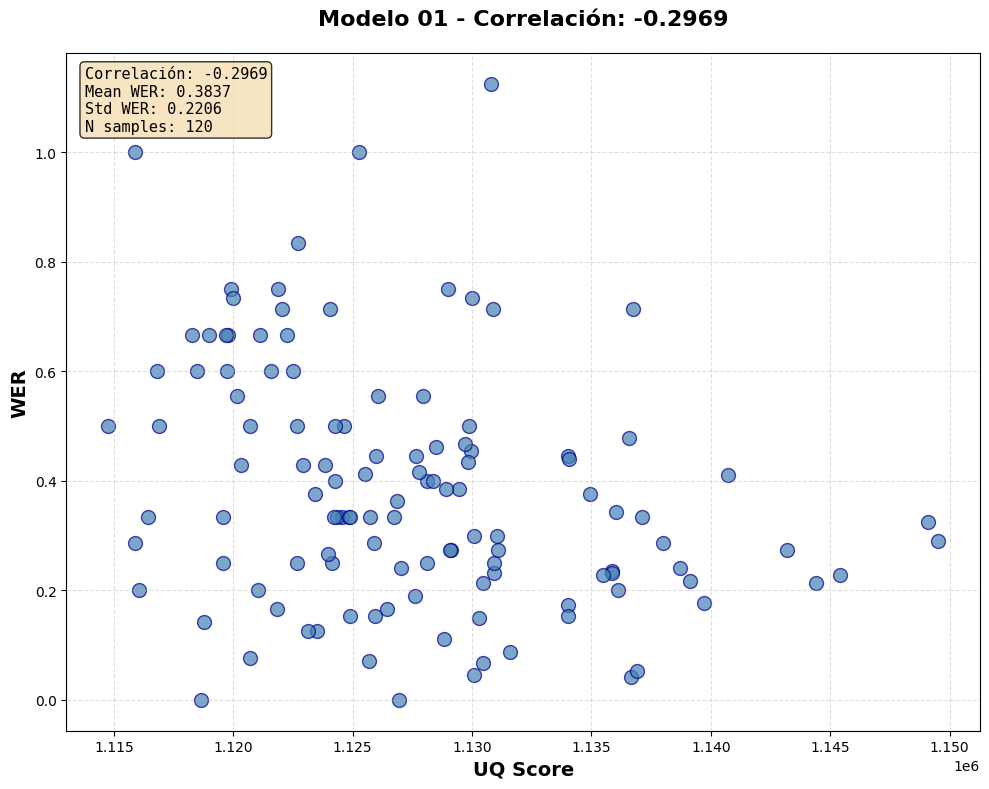

In [ ]:
def plot_single_model_detailed(uq_scores, wers, model_id, correlation, save_path=None):
    """
    Genera gráfico detallado para un modelo individual.
    Similar a tu segunda imagen.
    """
    plt.figure(figsize=(10, 8))

    # Scatter plot principal
    plt.scatter(uq_scores, wers, alpha=0.7, s=100, color='steelblue', edgecolors='darkblue')

    # Etiquetas y título
    plt.xlabel("UQ Score", fontsize=14, fontweight='bold')
    plt.ylabel("WER", fontsize=14, fontweight='bold')
    plt.title(f"Modelo {model_id:02d} - Correlación: {correlation:.4f}",
              fontsize=16, fontweight='bold', pad=20)

    # Grid
    plt.grid(True, alpha=0.4, linestyle='--', linewidth=0.8)

    # Añadir estadísticas en el gráfico
    stats_text = (
        f"Correlación: {correlation:.4f}\n"
        f"Mean WER: {wers.mean():.4f}\n"
        f"Std WER: {wers.std():.4f}\n"
        f"N samples: {len(wers)}"
    )
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             fontsize=11,
             family='monospace')

    # Formato del eje x en notación científica si los valores son grandes
    if uq_scores.max() > 10000:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
        print(f"💾 Gráfico guardado en: {save_path}")

    plt.show()


# Ejemplo: graficar el modelo 1 con detalle
if len(uq_list) > 0:
    plot_single_model_detailed(
        uq_list[0],
        wer_list[0],
        model_id=1,
        correlation=corr_list[0],
        save_path="modelo_01_detallado.png"
    )

📊 Generando gráfico para Modelo 01...
💾 Gráfico guardado en: plots_individuales/modelo_01_correlacion.png


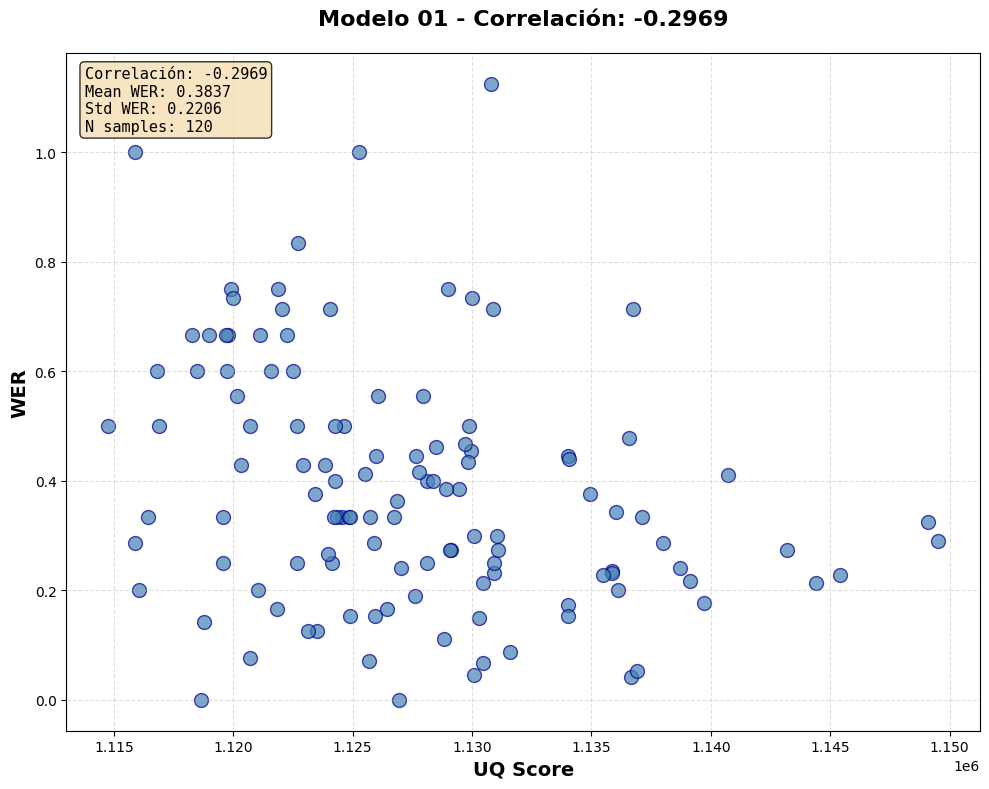

📊 Generando gráfico para Modelo 02...
💾 Gráfico guardado en: plots_individuales/modelo_02_correlacion.png


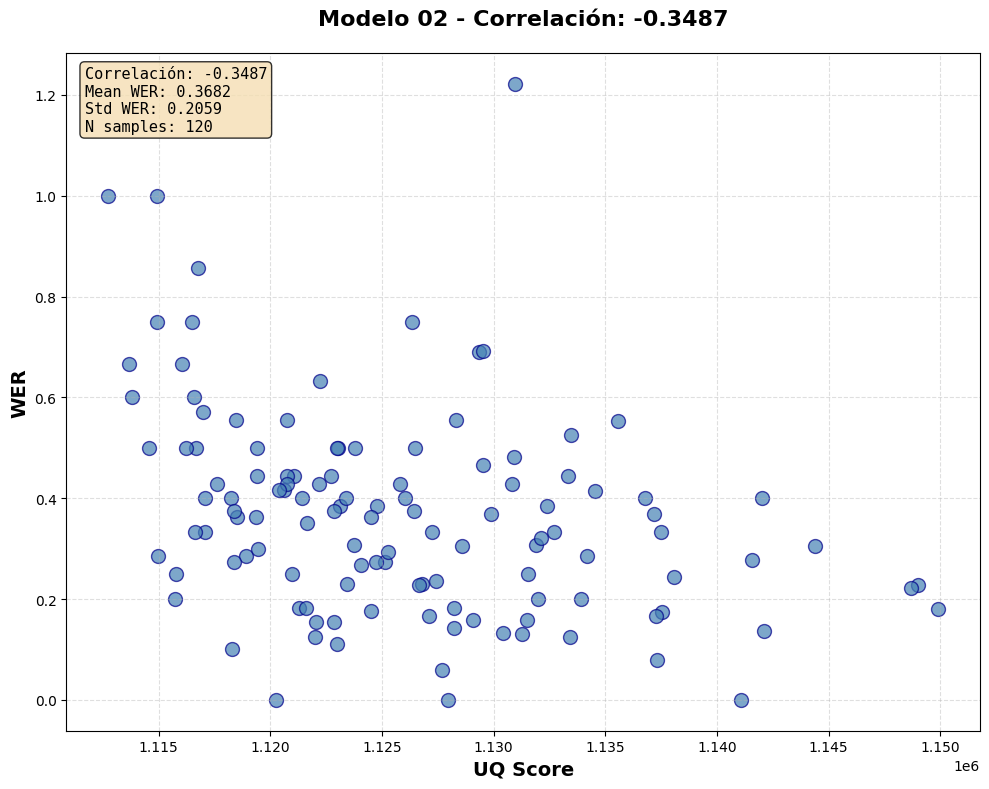

📊 Generando gráfico para Modelo 03...
💾 Gráfico guardado en: plots_individuales/modelo_03_correlacion.png


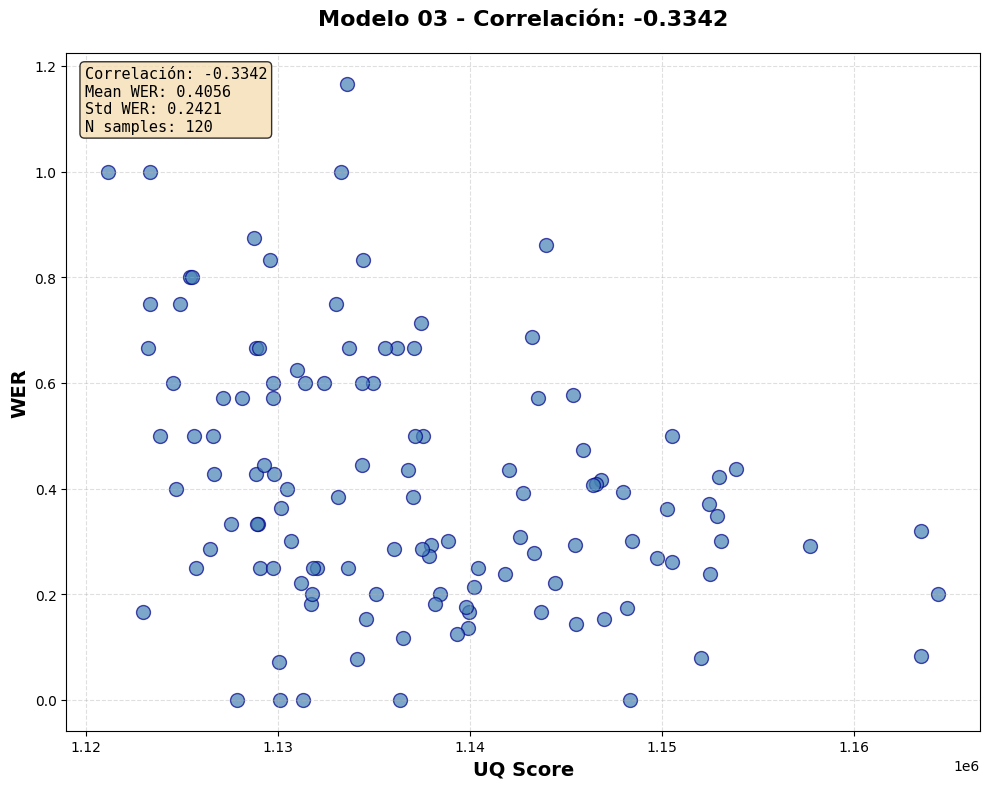

📊 Generando gráfico para Modelo 04...
💾 Gráfico guardado en: plots_individuales/modelo_04_correlacion.png


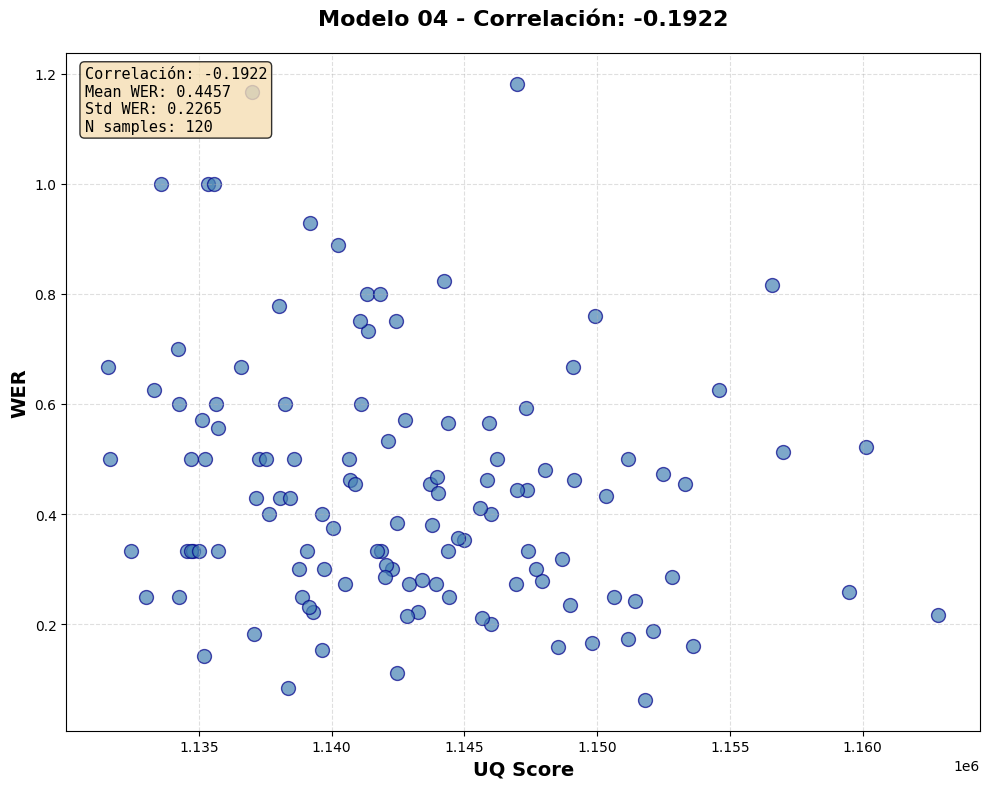

📊 Generando gráfico para Modelo 05...
💾 Gráfico guardado en: plots_individuales/modelo_05_correlacion.png


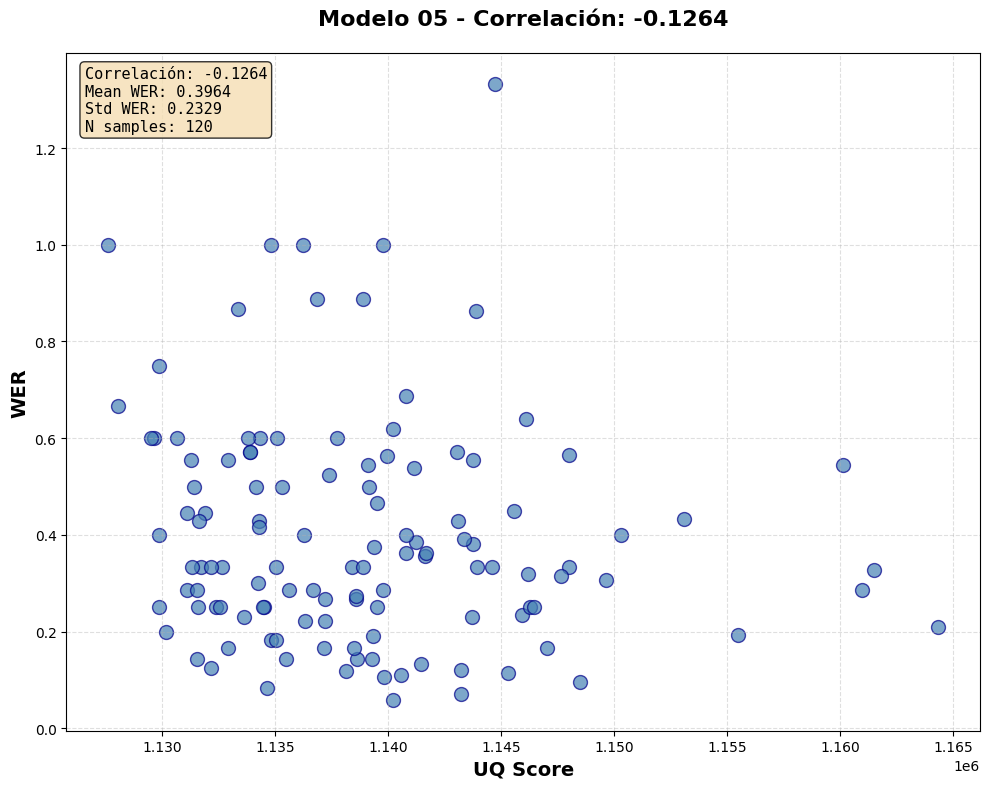

📊 Generando gráfico para Modelo 06...
💾 Gráfico guardado en: plots_individuales/modelo_06_correlacion.png


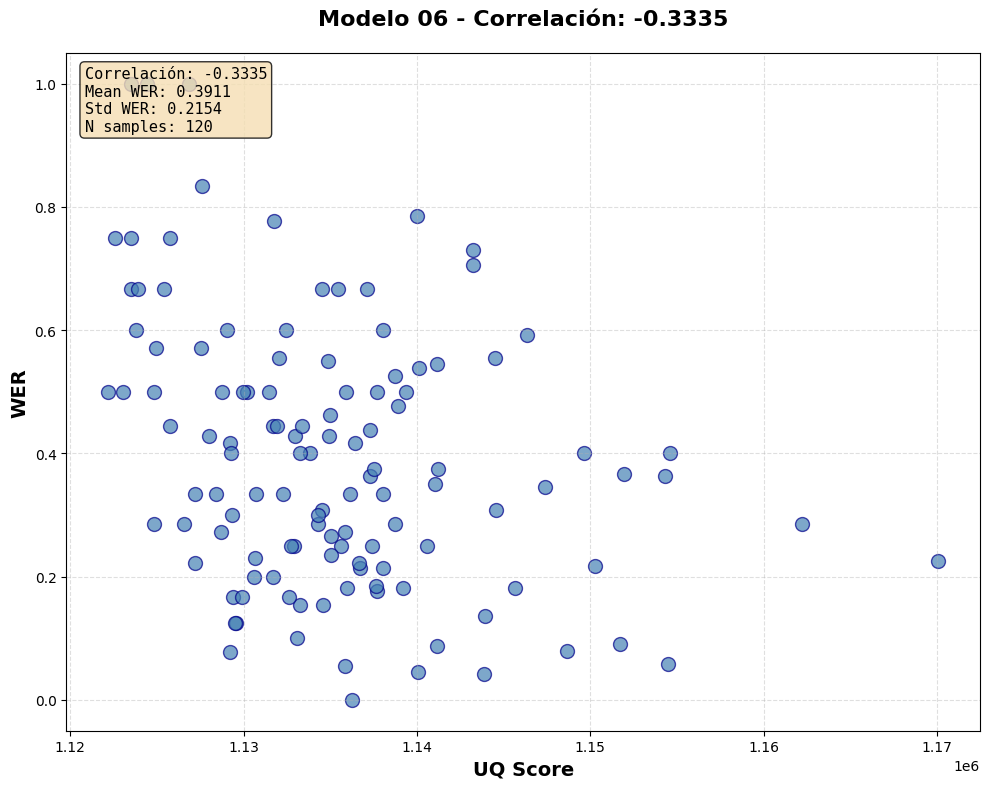

📊 Generando gráfico para Modelo 07...
💾 Gráfico guardado en: plots_individuales/modelo_07_correlacion.png


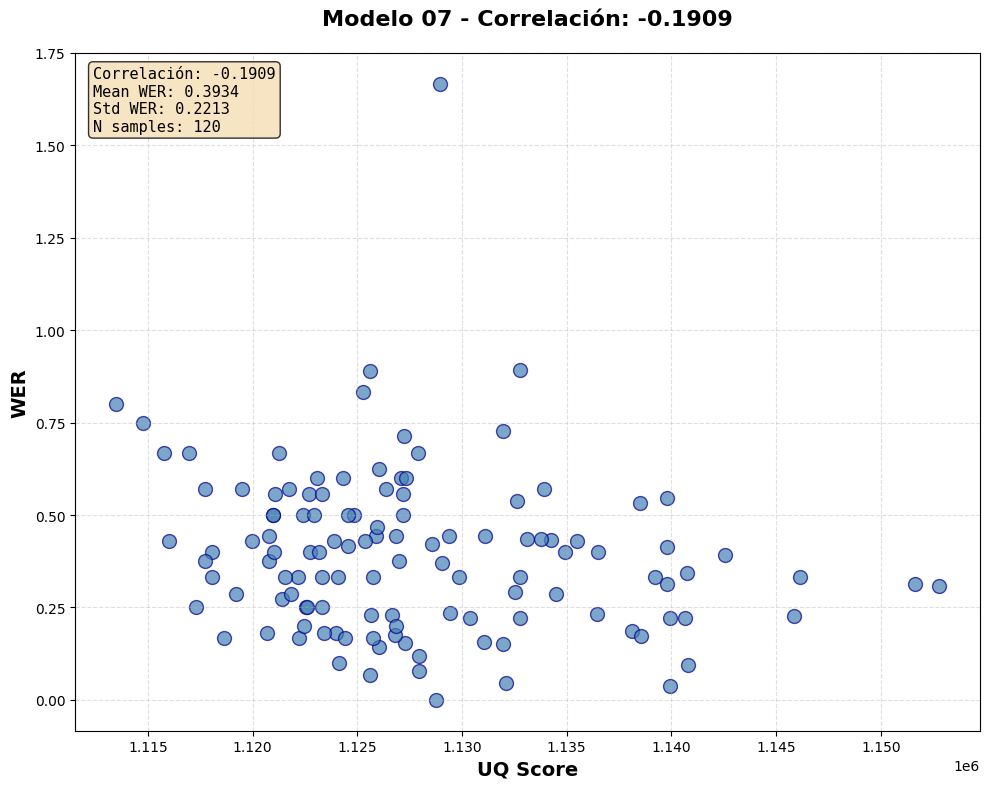

📊 Generando gráfico para Modelo 08...
💾 Gráfico guardado en: plots_individuales/modelo_08_correlacion.png


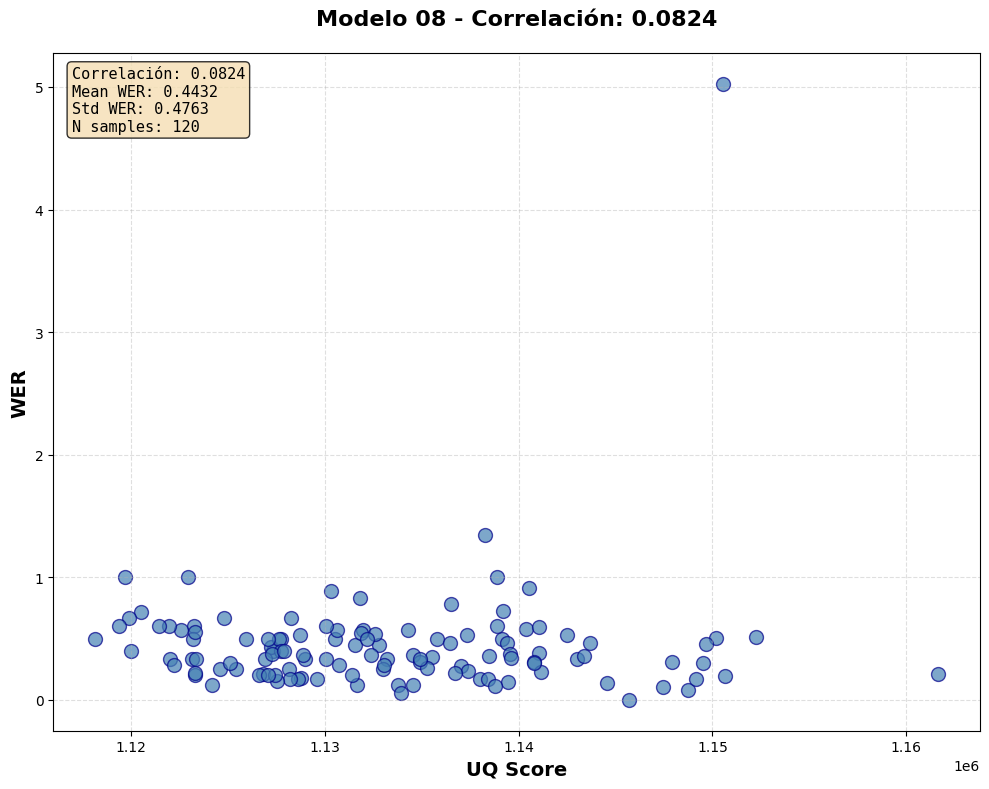

📊 Generando gráfico para Modelo 09...
💾 Gráfico guardado en: plots_individuales/modelo_09_correlacion.png


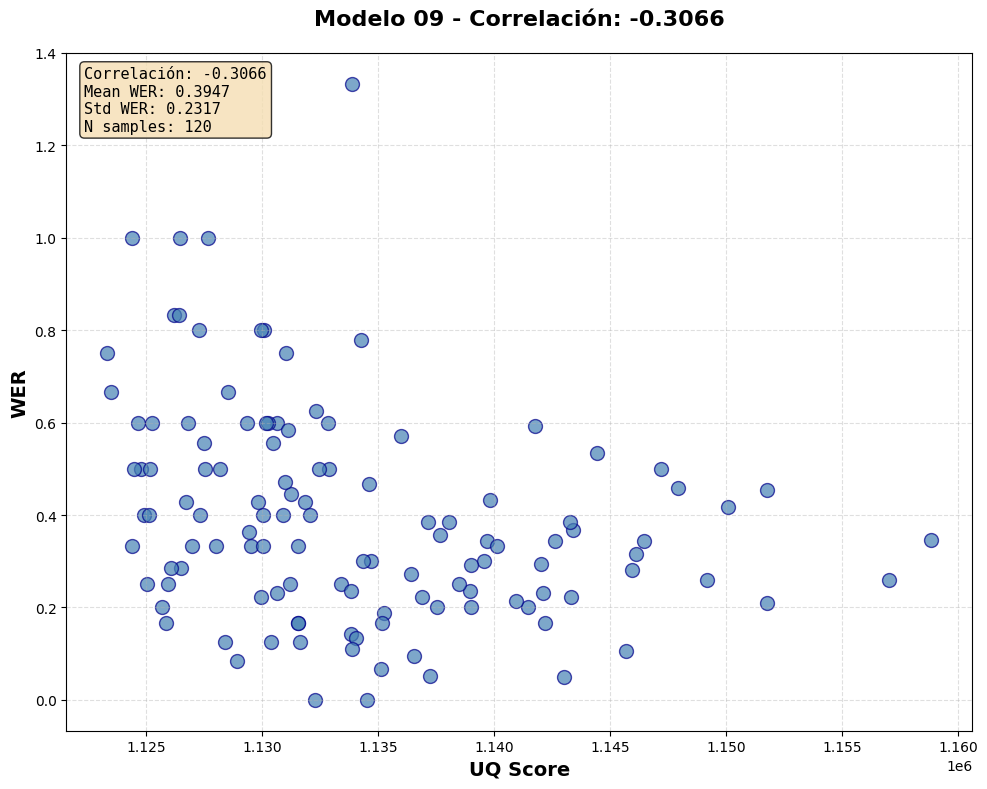

📊 Generando gráfico para Modelo 10...
💾 Gráfico guardado en: plots_individuales/modelo_10_correlacion.png


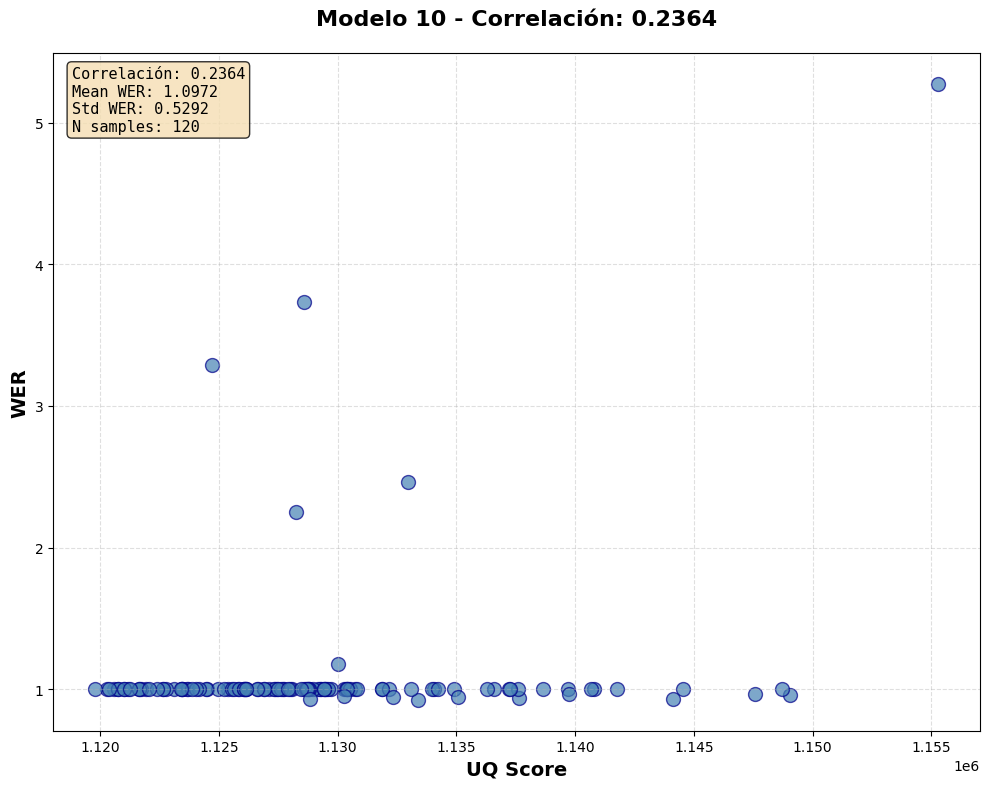


✅ 10 gráficos generados en carpeta 'plots_individuales/'


In [ ]:
def generate_all_individual_plots(uq_list, wer_list, corr_list, model_ids=range(1, 11)):
    """
    Genera un gráfico individual detallado para cada modelo.
    """
    import os
    os.makedirs("plots_individuales", exist_ok=True)

    for idx, model_id in enumerate(model_ids):
        if idx < len(uq_list):
            print(f"📊 Generando gráfico para Modelo {model_id:02d}...")
            plot_single_model_detailed(
                uq_list[idx],
                wer_list[idx],
                model_id=model_id,
                correlation=corr_list[idx],
                save_path=f"plots_individuales/modelo_{model_id:02d}_correlacion.png"
            )

    print(f"\n✅ {len(uq_list)} gráficos generados en carpeta 'plots_individuales/'")

# Generar todos los gráficos individuales
generate_all_individual_plots(uq_list, wer_list, corr_list)